In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# custom imports
from blackjack import Blackjack
from algorithms import epsilon_greedy_policy, sarsa_lamdba, gen_episode, pomdp_monte_carlo
from utils import softmax

In [39]:
%load_ext autoreload
%autoreload 2

In [2]:
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


## Single Case Testing

In [15]:
bj = Blackjack(mode='pomdp', verbose=True)

Initilized a pomdp Blackjack game with 48 cards


In [16]:
bj.start(ret_hand=True)

[12, 6]

In [17]:
print(bj.ph, bj.dh)

[('S', 2), ('C', 10)] [('S', 6), ('H', 10)]


In [18]:
print(len(bj.deck))

44


In [19]:
bj.step_agent((bj.ph, bj.dh), 'hit')

([0, 0], -1, 10)

In [20]:
bj.ph

[('S', 2), ('C', 10), ('S', 10)]

In [21]:
print(len(bj.deck))

43


In [22]:
bj.step_agent((bj.ph, bj.dh), 'hit')

([0, 0], -1, 10)

In [23]:
bj.ph

[('S', 2), ('C', 10), ('S', 10), ('D', 4)]

In [24]:
bj.dh

[('S', 6), ('H', 10)]

In [41]:
conv_actions = np.vectorize(lambda x: bj.actions.index(x))

## SARSA($\lambda$)

### Fully Observed MDP

In [187]:
n_ep = int(10e4)

In [188]:
Q = sarsa_lamdba(0.9, Blackjack, 'full', n_ep=n_ep)

In [189]:
V = Q.max(axis=2)

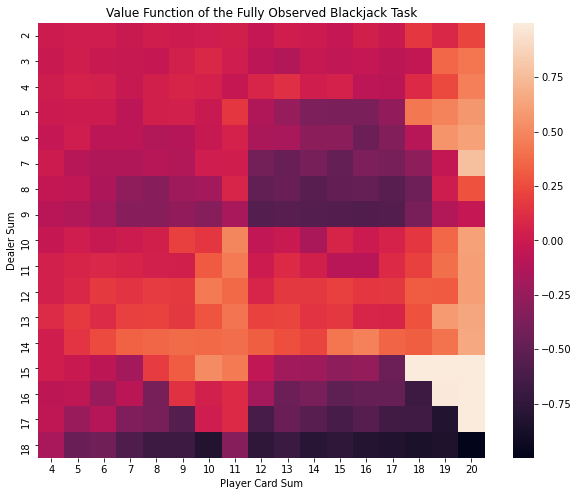

In [197]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(V[4:21,4:21].T, ax=ax);
ax.set(title="Value Function of the Fully Observed Blackjack Task",
       xticklabels = np.arange(4,21),
       xlabel = 'Player Card Sum',
       yticklabels = np.arange(2,21),
       ylabel = 'Dealer Sum');
plt.savefig('../figures/full_v.png')

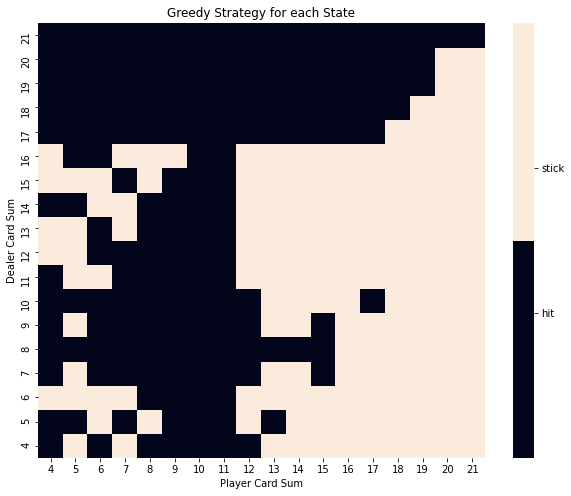

In [191]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data=np.argmax(Q, axis=2)[4:22,4:22].T, ax=ax, cbar_kws={"boundaries": np.linspace(-1, 2, 3)})
ax.set_yticklabels(np.arange(4,22))
ax.set_xticklabels(np.arange(4,22))
ax.invert_yaxis()

# colorbar modifications
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['hit', 'stick'])

plt.xlabel('Player Card Sum');
plt.ylabel('Dealer Card Sum');
plt.title("Greedy Strategy for each State");
plt.savefig('../figures/full_pi.png')

### MDP with Hidden Card

In [341]:
Q_h = sarsa_lamdba(0.9, Blackjack, 'hidden', n_ep=n_ep)

In [344]:
V_h = Q_h.max(axis=2)

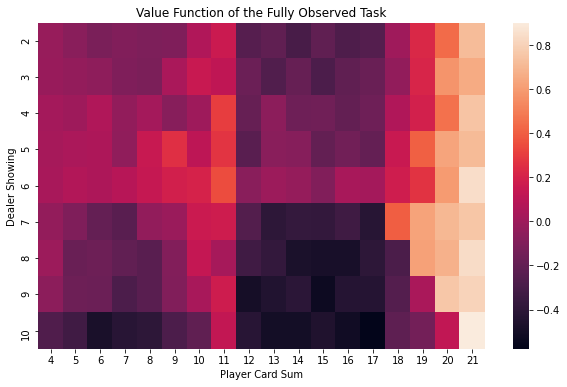

In [345]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(V_h[4:,2:].T, ax=ax);
ax.set(title="Value Function of the Fully Observed Task",
       xticklabels = np.arange(4,22),
       xlabel = 'Player Card Sum',
       yticklabels = np.arange(2,11),
       ylabel = 'Dealer Showing');
plt.savefig('../figures/hidden_v.png')

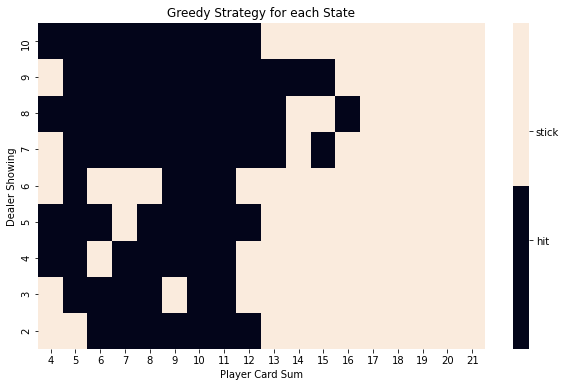

In [346]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=np.argmax(Q_h, axis=2)[4:,2:].T, ax=ax, cbar_kws={"boundaries": np.linspace(-1, 2, 3)})
ax.set_yticklabels(np.arange(2,11))
ax.set_xticklabels(np.arange(4,22))
ax.invert_yaxis()

# colorbar modifications
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['hit', 'stick'])

plt.xlabel('Player Card Sum');
plt.ylabel('Dealer Showing');
plt.title("Greedy Strategy for each State");
plt.savefig('../figures/hidden_pi.png')

## POMDP

In [192]:
pi, Q_s, N, Np, P = pomdp_monte_carlo(Blackjack, 'sample', n_ep=5*n_ep)

In [304]:
pi_m, Q_m, N_m, Np_m, P_m = pomdp_monte_carlo(Blackjack, 'max', n_ep=10*n_ep)

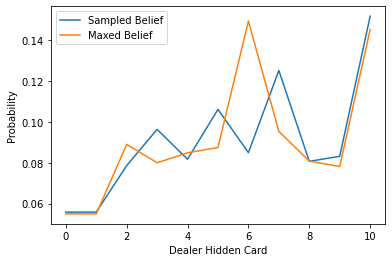

In [122]:
# sample of a distribution learned by the agent
plt.plot(softmax(P[20][4]), label='Sampled Belief');
plt.plot(softmax(P_m[20][4]), label='Maxed Belief');
plt.xlabel('Dealer Hidden Card');
plt.ylabel('Probability');
plt.legend(loc='best');
plt.savefig('../figures/beliefs.png')

In [139]:
P_max = np.argmax(P, axis=2)

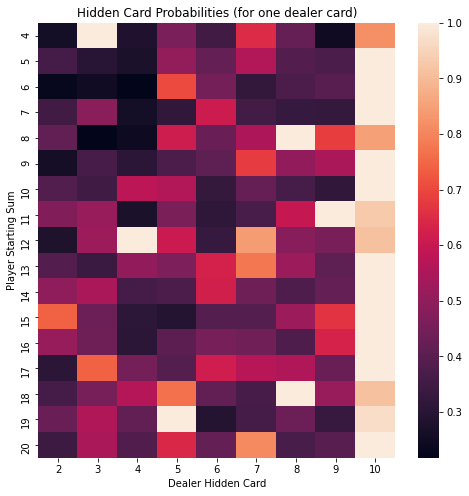

In [158]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(P[:,4][4:21,2:], ax=ax);
ax.set(title="Hidden Card Probabilities (for one dealer card)",
       xticklabels = np.arange(2,11),
       xlabel = 'Dealer Hidden Card',
       yticklabels = np.arange(4,21),
       ylabel = 'Player Starting Sum');
plt.savefig('../figures/belief_probs.png')

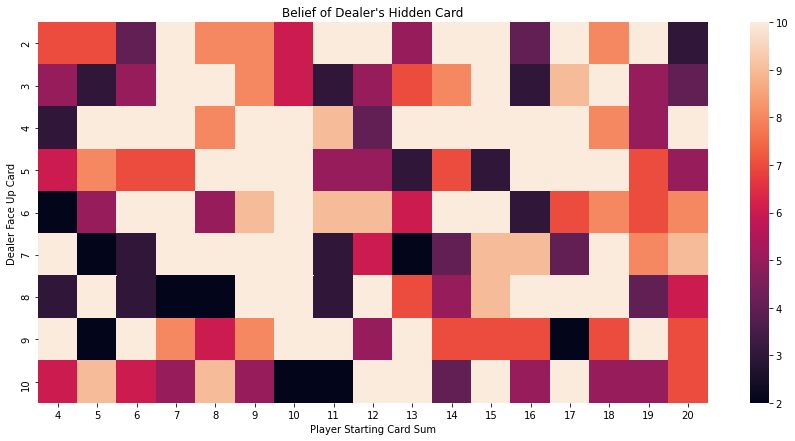

In [151]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(P_max[4:21,2:].T, ax=ax);
ax.set(title="Belief of Dealer's Hidden Card",
       xticklabels = np.arange(4,21),
       xlabel = 'Player Starting Card Sum',
       yticklabels = np.arange(2,11),
       ylabel = 'Dealer Face Up Card');
plt.savefig('../figures/belief_distr.png')

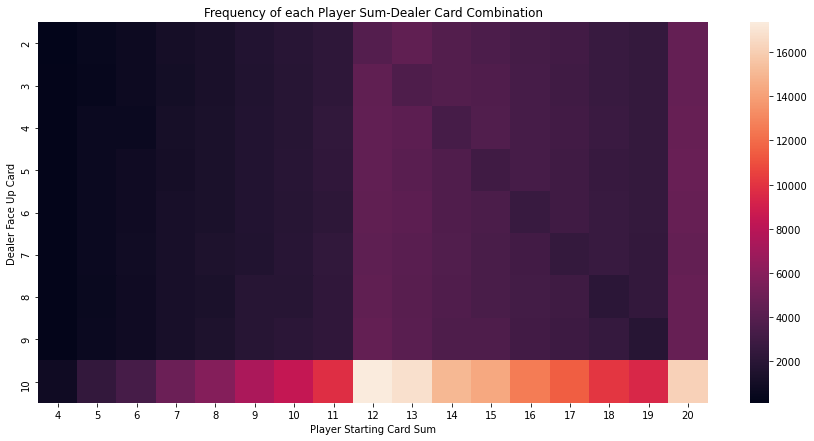

In [160]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(Np[4:21,2:].T, ax=ax);
ax.set(title="Frequency of each Player Sum-Dealer Card Combination",
       xticklabels = np.arange(4,21),
       xlabel = 'Player Starting Card Sum',
       yticklabels = np.arange(2,11),
       ylabel = 'Dealer Face Up Card');
plt.savefig('../figures/start_counts.png')

In [194]:
V_s = np.max(Q_s, axis=2)
V_m = np.max(Q_m, axis=2)

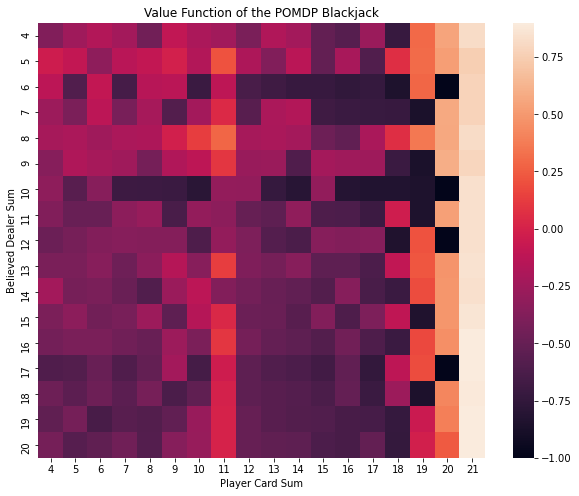

In [305]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(V_s[4:22,4:21].T, ax=ax);
ax.set(title="Value Function of the POMDP Blackjack",
       xticklabels = np.arange(4,22),
       xlabel = 'Player Card Sum',
       yticklabels = np.arange(4,21),
       ylabel = 'Believed Dealer Sum');
plt.savefig('../figures/pomdp_s_V.png')

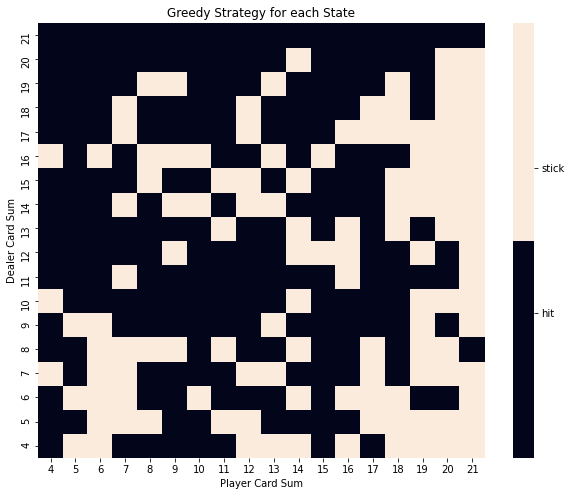

In [347]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data=np.argmax(Q_m, axis=2)[4:22,4:22].T, ax=ax, cbar_kws={"boundaries": np.linspace(-1, 2, 3)})
ax.set_yticklabels(np.arange(4,22))
ax.set_xticklabels(np.arange(4,22))
ax.invert_yaxis()

# colorbar modifications
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['hit', 'stick'])

plt.xlabel('Player Card Sum');
plt.ylabel('Dealer Card Sum');
plt.title("Greedy Strategy for each State");
plt.savefig('../figures/')

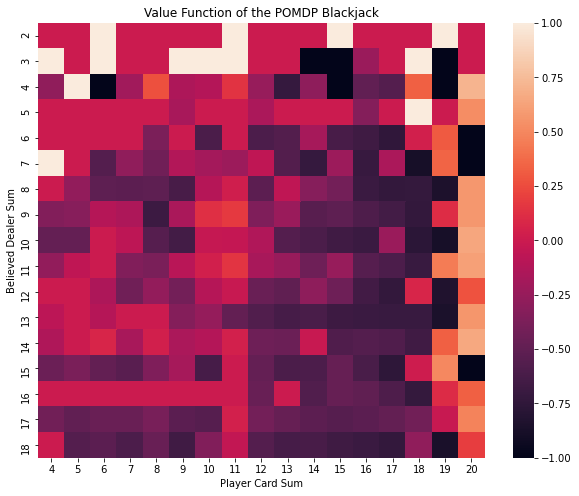

In [313]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(V_m[4:21,4:21].T, ax=ax);
ax.set(title="Value Function of the POMDP Blackjack",
       xticklabels = np.arange(4,21),
       xlabel = 'Player Card Sum',
       yticklabels = np.arange(2,21),
       ylabel = 'Believed Dealer Sum');
plt.savefig('../figures/pomdp_m_V.png')

## Comparisions

In [348]:
def simulate(env, pi, mode, n_ep=1000):
    """Evaluates learned action-value functions by calculating the average # of games won.
    
    env: constructor
    pi: policy
    """
    r_list = []
    for i in range(n_ep):
        world = env(mode=mode)
        s = world.start(ret_hand=True)
        while s!= world.terminal:
            a = pi[tuple(s)]
            s_n, r, _ = world.step_agent(s, a)
            s = s_n
        r_list.append(r)
    return r_list

In [349]:
conv_Q = np.vectorize(lambda x: bj.actions[x])

In [350]:
pi_full = conv_Q(np.argmax(Q, axis=2))
pi_hidden = conv_Q(np.argmax(Q_h, axis=2))

In [351]:
rs_full = np.array(simulate(Blackjack, pi_full, mode='full', n_ep=1000))
rs_hidden = np.array(simulate(Blackjack, pi_hidden, mode='hidden', n_ep=1000))

In [352]:
rs_pomdp = []
for i in range(1000):
    _, _, rh, _ = gen_episode(Blackjack, pi_m, P_m, mode='pomdp', belief='max')
    rs_pomdp.append(rh[-1])
rs_pomdp = np.array(rs_pomdp)

In [360]:
rs_pomdp2 = []
for i in range(1000):
    _, _, rh, _ = gen_episode(Blackjack, pi, P, mode='pomdp', belief='sample')
    rs_pomdp2.append(rh[-1])
rs_pomdp2 = np.array(rs_pomdp2)

In [362]:
rf = np.sum(rs_full > 0)/len(rs_full)
rh = np.sum(rs_hidden > 0)/len(rs_hidden)
rp = np.sum(rs_pomdp > 0)/len(rs_pomdp)
rp2 = np.sum(rs_pomdp2 > 0)/len(rs_pomdp2)

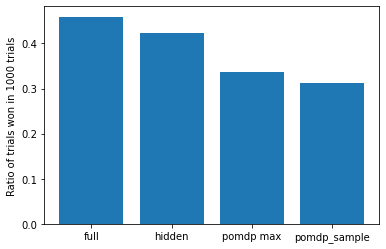

In [363]:
plt.bar(['full', 'hidden', 'pomdp max', 'pomdp_sample'], [rf, rh, rp, rp2])
plt.ylabel("Ratio of trials won in 1000 trials");
plt.savefig('../figures/final.png')